# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import os
from unidecode import unidecode
import string

In [2]:
figures_path = './figures/'
model_path = '../model/'

# Méthodes Utiles

In [3]:
def shape(df):
    nrows, ncols = df.shape
    print(f"{nrows} rows x {ncols} columns")

# Pour ce projet nous  ne compterons pas `$`
# comme une ponctuations mais un symbole monétaire
punctuation_chars = list(string.punctuation.replace('$', ''))

# Data Loading 

In [4]:
file = "../data/SMSSpamCollection.csv"

In [5]:
# quoting = 3 prevent " interpretation by pandas
df_msg = pd.read_csv(file, names=['class', 'sms'], delimiter="\t", quoting=3, encoding='utf-8')
shape(df_msg)

5574 rows x 2 columns


# Preprocessing

Avant de commencer à nettoyer les données, regardons le nombre d'exemple dans chaque catégories.

## Répartition de classes

In [6]:
df_msg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   5574 non-null   object
 1   sms     5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
df_msg.describe()

,class,sms
count,5574,5574
unique,2,5171
top,ham,"Sorry, I'll call later"
freq,4827,30


Les données ne contiennent que deux classes. La classe la plus représentée concerne les message légitime et concernant le contenu des messages, le message `Sorry, I'll call later` est présent $30$ fois dans le jeu de données. Nous avons des doublons qu'il faudra enlever.

In [8]:
df_classCounts = df_msg['class'].value_counts().reset_index()
df_classCounts

,class,count
0,ham,4827
1,spam,747


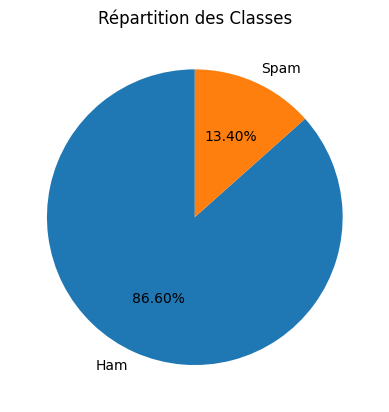

In [9]:
fig, ax = plt.subplots()
ax.pie(df_classCounts['count'], labels=df_classCounts['class'].str.title(), startangle=90, autopct='%.2f%%')
plt.title("Répartition des Classes")
fig.savefig(figures_path + 'class_repartition.png')
plt.show()

Le dataset contient $86.60\%$ de messages légitime contre seulement $13.40\%$ de messages spam. Le jeu de données est très déséquilibré. Ce qui pourra affecté les performances des modèles que nous utiliserons par la suite.

## Supression des doublons

In [10]:
df_msg[df_msg.duplicated()]

,class,sms
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls
...,...,...
5526,spam,You are awarded a SiPix Digital Camera! call 0...
5537,ham,"I know you are thinkin malaria. But relax, chi..."
5541,ham,Just sleeping..and surfing
5555,ham,Hahaha..use your brain dear


In [11]:
df_msg.loc[df_msg.duplicated(), 'class'].value_counts().reset_index()

,class,count
0,ham,309
1,spam,94


Nous avons des doublons dans les deux catégories. Regardons les $10$ messsages de type `ham` les plus présents.

In [12]:
df_msg.loc[df_msg.duplicated() & (df_msg['class'] == 'ham'), 'sms'].value_counts().reset_index().head(10)

,sms,count
0,"Sorry, I'll call later",29
1,I cant pick the phone right now. Pls send a me...,11
2,Ok...,9
3,7 wonders in My WORLD 7th You 6th Ur style 5th...,3
4,"Wen ur lovable bcums angry wid u, dnt take it ...",3
5,Your opinion about me? 1. Over 2. Jada 3. Kusr...,3
6,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...",3
7,Okie,3
8,Ok.,3
9,Ok,3


La plupart des ces messages sont sans doutes des messages proposés automatiquement comme : `Sorry, I'll call later` ou `Ok`. Un e autre chose intéressante concerne le traitement de la ponctuaction. A priori, `Ok`, `Ok.`, `Ok...` ou encore `Okie` correspondent sémantiquement à la même chose. Ceci sera pris en compte plus tard lors du traitement de la ponctuation et de l'étape de lemmatisation. Enfin on remarque aussi la présence de caractères d'entités HTML comme `&amp;` qui correspond au caractère `&`.

In [13]:
df_msg.loc[df_msg.duplicated() & (df_msg['class'] == 'spam'), 'sms'].value_counts().reset_index().head(10)

,sms,count
0,Please call our customer service representativ...,3
1,HMV BONUS SPECIAL 500 pounds of genuine HMV vo...,2
2,"Loan for any purpose £500 - £75,000. Homeowner...",2
3,I don't know u and u don't know me. Send CHAT ...,2
4,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,2
5,Camera - You are awarded a SiPix Digital Camer...,2
6,Your free ringtone is waiting to be collected....,1
7,No. 1 Nokia Tone 4 ur mob every week! Just txt...,1
8,You are a winner U have been specially selecte...,1
9,Free entry in 2 a wkly comp to win FA Cup fina...,1


Concernant les doublons de type spam, on remarque la présence de symboles monétaires `£`. Avant de continuer avec le nettoyage nous allons supprimer les doublons.

In [14]:
df_msg.drop_duplicates(inplace=True)
shape(df_msg)

5171 rows x 2 columns


In [15]:
df_classCounts = df_msg['class'].value_counts().reset_index()
df_classCounts

,class,count
0,ham,4518
1,spam,653


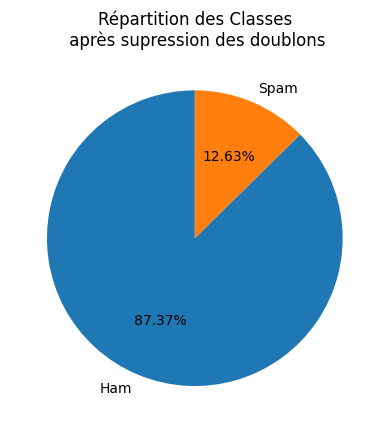

In [16]:
fig, ax = plt.subplots()
ax.pie(df_classCounts['count'], labels=df_classCounts['class'].str.title(), startangle=90, autopct='%.2f%%')
plt.title("Répartition des Classes\n après supression des doublons")
fig.savefig(figures_path + 'class_repartition_without_duplicates.png')
plt.show()

La répartition n'a pas été trop changée. Regardons plus en détail les caractères que nous avons dans le jeu de données.

## Caractères Spéciaux

In [17]:
# Extrait tout les caractères que ne sont ni alpha-numérique ni un espace
special_characters = df_msg['sms'].str.findall(r'([^a-zA-Z0-9\s])').explode().dropna()
# Compte le nombre de caractères spéciaux
special_characters_counts = special_characters.value_counts().reset_index()
special_characters_counts.rename(columns={'sms' : 'spec_chars'}, inplace=True)
special_characters_counts.loc[:, 'spec_chars'] = special_characters_counts['spec_chars'].apply(lambda x : repr(x))
special_characters_counts

,spec_chars,count
0,'.',10127
1,"','",1731
2,"""'""",1726
3,'?',1491
4,'!',1258
5,'&',818
6,';',681
7,':',652
8,'-',520
9,')',448


On peut remarquer plusieurs choses. Hormis la présence de caractères de ponctuation standard, il existe des caractères chinois (`〨` : chiffre huit, `鈥` : Holmium, élément chimique n°67), des caractères unicodes (`┾`, `»`, `…`, ...), des caractères non-imprimables (`'\x91'`, `'\x92'`, `'\x93'`, `'\x94'`, `'\x96'`). Ces caractères sont presque inexistants et proviennent probablement d'erreur d'encodage lors de la création du dataset. On a aussi des lettres accentuées, de la ponctuation espagnoles `¡`.

#### Caractéres \w non alpha-numérique

On remplace les caractères décris par le motif `\w` mais n'étant pas des caractères alphanumérique. En utilisant `unidecode` on obtiendra la meilleure approximation ASCII d'un caractére unicode. 

In [18]:
def to_ascii(x):
    """ Returns the best ASCII character approximation to `x`."""
    x_ascii = unidecode(x)
    if x_ascii.isnumeric() or ' ' in x_ascii : return ''
    return x_ascii
    

In [19]:
# list
special_characters = df_msg['sms'].str.findall(r'([^\W\da-zA-Z\s_])').explode().dropna().unique()
special_characters

array(['ú', 'ü', 'Ü', 'è', 'é', 'É', 'ì', '鈥', '〨'], dtype=object)

In [20]:
df_msg['sms'] = df_msg['sms'].str.replace(r'([^\W\da-zA-Z\s_])', lambda m: to_ascii(m.group(1)), regex=True)

In [21]:
special_characters = df_msg['sms'].str.findall(r'([^\W\da-zA-Z\s_])').explode().dropna().unique()
special_characters

array([], dtype=object)

#### Caractère non ascii

Pour cette classe de caractères on peut aussi utiliser la fonction `to_ascii`

In [22]:
# La class [ -~] désigne un caractère ASCII
special_characters = df_msg['sms'].str.findall(r'([^ -~£])').explode().dropna().unique()
special_characters

array(['\x92', '‘', '–', '…', '\x94', '“', '\x91', '’', '\x93', '\x96',
       '»', '—', '┾', '¡'], dtype=object)

In [23]:
# map produit par la fonction to_ascii
print([(x, to_ascii(x)) for x in special_characters])

[('\x92', ''), ('‘', "'"), ('–', '-'), ('…', '...'), ('\x94', ''), ('“', '"'), ('\x91', ''), ('’', "'"), ('\x93', ''), ('\x96', ''), ('»', '>>'), ('—', '--'), ('┾', '+'), ('¡', '!')]


In [24]:
df_msg['sms'] = df_msg['sms'].str.replace(r'([^ -~£])', lambda m: to_ascii(m.group(1)), regex=True)

In [25]:
special_characters = df_msg['sms'].str.findall(r'([^ -~£])').explode().dropna().unique()
special_characters

array([], dtype=object)

Si l'on regarde maintenant la liste des caractères spéciaux nous n'avons plus que des caractères de ponctuation et des symboles monétaires.

In [26]:
# Extrait tout les caractères que ne sont ni alpha-numérique ni un espace
special_characters = df_msg['sms'].str.findall(r'([^a-zA-Z0-9\s])').explode().dropna()
# Compte le nombre de caractères spéciaux
special_characters_counts = special_characters.value_counts().reset_index()
special_characters_counts.rename(columns={'sms' : 'spec_chars'}, inplace=True)

In [27]:
# Ponctuation 
mask = special_characters_counts['spec_chars'].isin(punctuation_chars)
special_characters_counts.loc[mask]

,spec_chars,count
0,.,10175
1,',1766
2,",",1731
3,?,1491
4,!,1260
5,&,818
6,;,681
7,:,652
8,-,531
9,),448


In [28]:
# Symboles monétaires or $ 
special_characters_counts.loc[~mask]

,spec_chars,count
13,£,272
21,$,23


## Entités HTML

Nous avons vu précédemment qu'il existe des enetités HTML dans les messages. Ceci est vient probablement du fait qu'une partie du dataset a été obtenu par le scrapping d'un site internet. Nous devons donc traiter ces entités HTML.

In [29]:
html_entities = df_msg['sms'].str.findall(r'(\&[^;]{,6}+;)').explode().dropna().unique()
html_entities

array(['&amp;', '&lt;', '&gt;'], dtype=object)

Nous n'avons que 3 type d'entités HTML dans le dataset. `&amp` peut temporairement être remplacé par `&`.

In [30]:
df_msg['sms'] = df_msg['sms'].str.replace('&amp;', '')

Concernant les entités `&lt;` et `&gt;` regardons dans quel context elles sont utilisés :

In [31]:
df_msg['sms'].str.findall(r'(\&(?:lt|gt)[^\s]+)').explode().dropna().value_counts().reset_index()

,sms,count
0,&lt;#&gt;,254
1,&lt;DECIMAL&gt;,18
2,&lt;TIME&gt;,6
3,&gt;:(,4
4,&lt;3,3
5,&lt;URL&gt;,2
6,&lt;),1
7,&lt;EMAIL&gt;,1


On constate que `&lt;` et `&gt` sont principalement utilisé pour indiquer une certain type d'information (email, url, time, decimal). Regardons à quoi correspond `&lt;#&gt;`. 

In [32]:
df_msg.loc[df_msg['sms'].str.contains('&lt;#&gt;'), 'sms']

44      Great! I hope you like your man well endowed. ...
51      A gram usually runs like  &lt;#&gt; , a half e...
78             Does not operate after  &lt;#&gt;  or what
178     Turns out my friends are staying for the whole...
200              Found it, ENC  &lt;#&gt; , where you at?
                              ...                        
5480                            No probably  &lt;#&gt; %.
5506             Wait . I will msg after  &lt;#&gt;  min.
5515    Yes. Please leave at  &lt;#&gt; . So that at  ...
5559    No. I meant the calculation is the same. That ...
5561    if you aren't here in the next  &lt;#&gt;  hou...
Name: sms, Length: 197, dtype: object

Il semble que `&lt;#&gt;` soit utilisé pour indiqué des données numériques. On peut remplacer `&lt;#&gt;` par `NUMBER`. 

In [33]:
def clean_markup(x):
    if x == '#' : return 'NUMBER'
    return x

df_msg.loc[:,'sms'] = df_msg['sms'].str.replace(r'\&lt;([^;]+)\&gt;', lambda m : clean_markup(m.group(1)), regex=True)

In [34]:
df_msg['sms'].str.findall(r'(\&(?:lt|gt)[^\s]+)').explode().dropna().value_counts().reset_index()

,sms,count
0,&gt;:(,4
1,&lt;3,3
2,&lt;),1


Le reste sont des emiticones. On les remplace par le text `EMOTICON`.

In [35]:
df_msg.loc[:,'sms'] = df_msg['sms'].str.replace(r'\&(?:lt|gt)[^\s]+', 'EMOTICON', regex=True)

In [36]:
html_entities = df_msg['sms'].str.findall(r'(\&[^;]{,6}+;)').explode().dropna().unique()
html_entities

array([], dtype=object)

Toutes les entités HTML on été enlevées.

In [37]:
# Extrait tout les caractères que ne sont ni alpha-numérique ni un espace
special_characters = df_msg['sms'].str.findall(r'([^a-zA-Z0-9\s])').explode().dropna()
# Compte le nombre de caractères spéciaux
special_characters_counts = special_characters.value_counts().reset_index()
special_characters_counts.rename(columns={'sms' : 'spec_chars'}, inplace=True)


mask = special_characters_counts['spec_chars'].isin(punctuation_chars)
special_characters_counts.loc[mask]

,spec_chars,count
0,.,10175
1,',1766
2,",",1731
3,?,1491
4,!,1260
5,:,648
6,-,531
7,),447
8,/,377
9,*,286


Regardons maintenant les messages contenant `#`.

In [38]:
df_msg.loc[df_msg['sms'].str.contains('#'), 'sms'].values

array(['okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm',
       'Boltblue tones for 150p Reply POLY# or MONO# eg POLY3 1. Cha Cha Slide 2. Yeah 3. Slow Jamz 6. Toxic 8. Come With Me or STOP 4 more tones txt MORE',
       'BIG BROTHER ALERT! The computer has selected u for 10k cash or #150 voucher. Call 09064018838. NTT PO Box CRO1327 18+ BT Landline Cost 150ppm mobiles vary',
       'Now, whats your house # again ? And do you have any beer there ?',
       'Urgent! Please call 09061743810 from landline. Your ABTA complimentary 4* Tenerife Holiday or #5000 cash await collection SAE T&Cs Box 326 CW25WX 150 ppm',
       "Plz note: if anyone calling from a mobile Co.  asks u to type # NUMBER  or # NUMBER . Do not do so. Disconnect the call,coz it iz an attempt of 'terrorist' to make use of the sim card no. Itz confirmd by nokia n motorola n has been verified by CNN IBN.",
    

Ici on remarque que le symbol `#` indique toujours une donnée de type numérique. Mais dans tous les cas il y a soit un nombre soit le mot number après. On peut donc enlever ce caractère.

In [39]:
df_msg.loc[:,'sms'] = df_msg['sms'].str.replace(r'#(\s*\w+)', lambda m : m.group(1), regex=True)

In [40]:
df_msg.loc[df_msg['sms'].str.contains('#'), 'sms'].values

array([], dtype=object)

Traitons le cas des émoticones

In [41]:
df_msg['sms'].str.findall(r'([^\w\s.!\?\)\(]+(?:\)|D|\())').explode().dropna().value_counts()

sms
:)      233
:-)      97
:-(      17
;-)      11
:(        9
;)        8
:-D       6
/D        5
-)        5
=D        5
+)        4
"D        3
:D        3
,D        3
-D        2
;-(       2
":-)      1
:"D       1
=)        1
Name: count, dtype: int64

On remplace aussi ces motifs par le text `EMOTICON` :

In [42]:
df_msg.loc[:,'sms'] = df_msg['sms'].str.replace(r'([^\w\s.!\?\)\(]+(?:\)|D|\())', 'EMOTICON', regex=True)

In [43]:
df_msg['sms'].str.findall(r'([^\w\s.!\?\)\(]+(?:\)|D|\())').explode().dropna().value_counts()

Series([], Name: count, dtype: int64)

Considérons le symbole `&` : 

In [44]:
df_msg.loc[df_msg['sms'].str.contains('&'), 'sms'].values

array(["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       'URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18',
       'Urgent UR awarded a complimentary trip to EuroDisinc Trav, Aco&Entry41 Or £1000. To claim txt DIS to 87121 18+6*£1.50(moreFrmMob. ShrAcomOrSglSuplt)10, LS1 3AJ',
       'here is my new address -apples&pairs&all that malarky',
       "You'll not rcv any more msgs from the chat svc. For FREE Hardcore services text GO to: 69988 If u get nothing u must Age Verify with yr network & try again",
       '500 New Mobiles from 2004, MUST GO! Txt: NOKIA to No: 89545 & collect yours today!From ONLY £1 www.4-tc.biz 2optout 087187262701.50gbp/mtmsg18',
       'Text & meet someone sexy today. U can find a date or even flirt its up to U. Join 4 just 10p. REPLY with NA

In [45]:
df_msg['sms'] = df_msg['sms'].str.replace('&', 'and', regex=True)

## Remplacement des email

In [46]:
df_msg['sms'] = df_msg['sms'].str.replace(r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}', 'EMAIL', regex=True)

## Remplacement des urls

In [47]:
df_msg['sms'] = df_msg['sms'].str.replace(r'(https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z]{2,}(\.[a-zA-Z]{2,})(\.[a-zA-Z]{2,})?\/[a-zA-Z0-9]{2,}|((https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z]{2,}(\.[a-zA-Z]{2,})(\.[a-zA-Z]{2,})?)|(https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z0-9]{2,}\.[a-zA-Z0-9]{2,}\.[a-zA-Z0-9]{2,}(\.[a-zA-Z0-9]{2,})?', 'URL',regex=True)

In [48]:
# Extrait tout les caractères que ne sont ni alpha-numérique ni un espace
special_characters = df_msg['sms'].str.findall(r'([^a-zA-Z0-9\s])').explode().dropna()
# Compte le nombre de caractères spéciaux
special_characters_counts = special_characters.value_counts().reset_index()
special_characters_counts.rename(columns={'sms' : 'spec_chars'}, inplace=True)


mask = special_characters_counts['spec_chars'].isin(punctuation_chars)
special_characters_counts.loc[mask]

,spec_chars,count
0,.,9702
1,',1766
2,",",1728
3,?,1491
4,!,1260
5,-,390
6,/,342
7,*,286
8,"""",279
10,:,271


In [49]:
df_msg.loc[df_msg['sms'].str.contains('@'), 'sms'].values

array(['Do you know what Mallika Sherawat did yesterday? Find out now @  URL',
       "Want 2 get laid tonight? Want real Dogging locations sent direct 2 ur mob? Join the UK's largest Dogging Network bt Txting GRAVEL to 69888! Nt. ec2a. 31p.msg@150p",
       'Text and meet someone sexy today. U can find a date or even flirt its up to U. Join 4 just 10p. REPLY with NAME and AGE eg Sam 25. 18 -msg recd@thirtyeight pence',
       "Want 2 get laid tonight? Want real Dogging locations sent direct 2 ur Mob? Join the UK's largest Dogging Network by txting MOAN to 69888Nyt. ec2a. 31p.msg@150p",
       'from URL MonthlySubscription@50p/msg max6/month TandCsC web age16 2stop txt stop',
       'XCLUSIVE@CLUBSAISAI 2MOROW 28/5 SOIREE SPECIALE ZOUK WITH NICHOLS FROM URL ROSES 2 ALL LADIES !!! info: 07946746291/07880867867 ',
       'Where @',
       'Msgs r not time URL silently say that I am thinking of U right now and also making U think of me at least 4 a moment. Gd URL drms @Shesil',
       '"H

In [50]:
import nltk
import re
import ssl

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /home/jonathan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jonathan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jonathan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jonathan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
class TextProcessor:
    def __init__(self, language='english'):
        # Initialize lemmatizer
        self.lemmatizer = WordNetLemmatizer()
        
        # Get stopwords
        self.stop_words = set(stopwords.words(language))
    
    def process_text(self, text):
        # Tokenize while preserving punctuation
        tokens = word_tokenize(text)
        
        # Lemmatize and filter tokens
        processed_tokens = []
        for token in tokens:
            # Check if token is an alphanumeric word
            if token.isalnum():
                # Lemmatize and convert to lowercase
                lemma = self.lemmatizer.lemmatize(token.lower())
                
                # Explicitly remove stop words
                if lemma not in self.stop_words:
                    processed_tokens.append(lemma)
            else:
                # Keep punctuation and other non-alphanumeric tokens
                processed_tokens.append(token)
        
        return processed_tokens

In [52]:
processor = TextProcessor()


df_msg['sms'] = df_msg['sms'].apply(lambda x : ' '.join(processor.process_text(x)) if pd.notna(x) else '')

## Sauvegarde des données nettoyée

In [53]:
df_msg.to_csv('cleaned_data.csv')

# Longueur des SMS

In [54]:
df_msg['sms_length'] = df_msg['sms'].apply(lambda x : len(x))

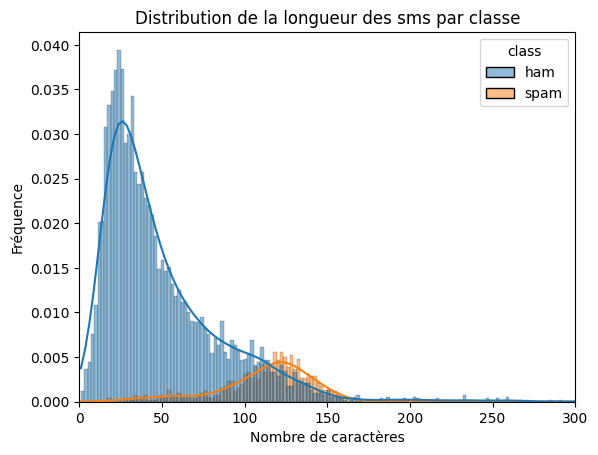

In [547]:
fig, ax = plt.subplots()
sns.histplot(df_msg, x='sms_length', hue='class', stat='proportion', bins=250, kde=True, ax=ax)
plt.title('Distribution de la longueur des sms par classe')
ax.set_ylabel('Fréquence')
ax.set_xlabel('Nombre de caractères')
ax.set_xlim(0, 300)
plt.show()
fig.savefig(figures_path + 'longueur_sms.png', bbox_inches='tight')

On remarque que les SMS légitimes on un nombre de caractère plus cours en moyenne. Regardons la distribution du nombre de caractères spéciaux par classe.

In [56]:
df_msg['nb_specchars'] = df_msg['sms'].str.findall(r'([^\w\s])').apply(lambda x : len(x))
df_msg['sms'].str.findall(r'([^\w\s])').explode().dropna().unique()

array([',', '.', '(', ')', "'", '!', '?', '£', '*', '>', '/', '+', ':',
       '=', '-', '`', '@', '$', '~', '|', ';', '<', '\\', '^', '%', '[',
       ']'], dtype=object)

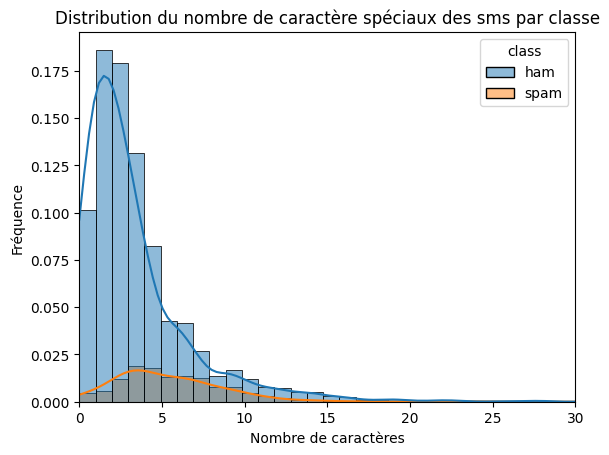

In [549]:
fig, ax = plt.subplots()
sns.histplot(df_msg, x='nb_specchars', hue='class', stat='proportion', bins=60, kde=True, ax=ax)
plt.title('Distribution du nombre de caractère spéciaux des sms par classe')
ax.set_ylabel('Fréquence')
ax.set_xlabel('Nombre de caractères')
ax.set_xlim(0, 30)
fig.savefig(figures_path + 'caractere_spec.png', bbox_inches='tight')
plt.show()

On observe que les spams contiennent un peu plus de caractères spéciaux que les ham. Ceci peut être du au fait qu'en plus des caractères de ponctuations standard les spam contiennent souvent des symboles monétaire, des urls. Pour cette raison dans le vectorizer nous utiliserons l'expression régulière suivante pour la génération des tokens  `r'[\w$£@%]+'`. 

# Data Vectorization

In [58]:
label_map = {'ham' : 0, 'spam' : 1}

X = df_msg['sms']
y = df_msg['class'].apply(lambda x : label_map[x])

In [59]:
from sklearn.model_selection import train_test_split

test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify=y)

In [60]:
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Pipeline Construction

Pour déterminer quel modèle nous allons utiliser, nous devons construire une pipeline de traitement du texte transformant des données brutes en prédictions de classe. Nous utiliserons par un vectoriseur TF-IDF, connu pour ses performances en classification de texte. Ensuite, nous ajoutons une SVD tronquée qui va au-delà de la simple réduction dimensionnelle : plutôt que de simplement supprimer des caractéristiques, cette technique capture les relations sémantiques sous-jacentes, créant des composantes plus abstraites et significatives qui préservent l'essence informationnelle des documents originaux. Cette approche nous permet de compresser intelligemment l'information tout en réduisant le bruit.

Après la SVD tronqué nous pouvons utilisé un directement un classificateur, l'ajout d'un scaler détériore les performances. Pour touver les nombre de composante optimales pour la SVD tronquée, nous pouvons regarder la variance expliquée en fonction du nombre de composante. En suivant l'approche d'écrite par [Antonella Falini](https://www.sciencedirect.com/science/article/pii/S2772415822000244), on choisit un numbre de composantes tel qu'un seuil d'au moins 70% de variance expliquée soit atteint.

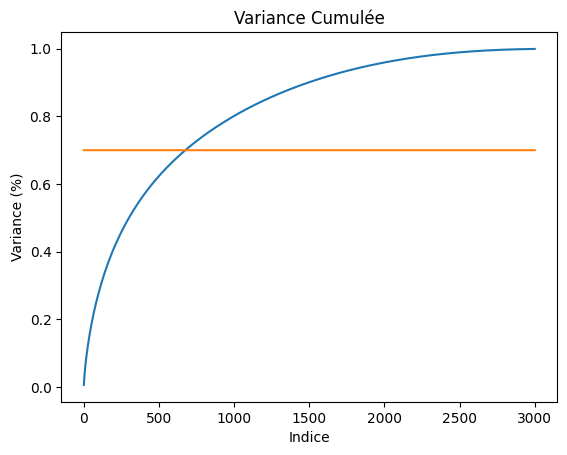

In [561]:
import numpy as np
max_components = 3000
pattern = r'\b[A-Za-z0-9\$£@%]+\b'
pipe = Pipeline([('vec', TfidfVectorizer(max_features=5000, token_pattern=pattern)), ('svd', TruncatedSVD(n_components=max_components))])

pipe.fit(X_train, y_train)
explained_variances = pipe['svd'].explained_variance_ratio_
cumulative_variances = np.cumsum(explained_variances)

# Plotting
fig, ax = plt.subplots()

x_var = np.arange(1, len(explained_variances) + 1)
# Cumulative variance

ax.plot(x_var, cumulative_variances)
ax.plot(x_var, 0*x_var + 0.7)
plt.title('Variance Cumulée')
plt.xlabel('Indice')
plt.ylabel('Variance (%)')
fig.savefig(figures_path + 'var_cum.png', bbox_inches='tight')
plt.show()

Le nombre de composante pour lequel ceci est vérifié est de :

In [140]:
n_components = np.argmin((cumulative_variances - 0.7)**2)
n_components

np.int64(675)

Nous prendrons donc 675 composantes pour la SVD tronquée.

In [141]:
pattern = r'\b[A-Za-z0-9\$£@%]+\b'

pipe = Pipeline([('vec', TfidfVectorizer(max_features=5000, token_pattern=pattern)), ('svd', TruncatedSVD(n_components=n_components)), ('clf', SVC(probability=True))])

In [142]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9851804123711341

# Modèles : Machine Learning 

Dans cette section nous allos utiliser la méthode Gridsearch avec cross-validation pour déterminer les meilleurs paramètres pour un modèle en particulier.

Les modèles que nous allons tester sont :
* SVM (Support Vector Machine)
* Regression Logistique
* Naive Bayes Gaussien
* K-Nearest Neighbors
* Forêts Aléatoires
* Arbres de décisions

In [455]:
# Sci-Kit Learn models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef,confusion_matrix, classification_report, precision_recall_curve, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold

gridsearch_path = './gridsearch/'

In [258]:
from joblib import parallel_backend
class GridSearchOptimizer:
    def __init__(self, pipeline, param_grid):
        self.pipeline = pipeline
        self.param_grid = param_grid
        
        self.grid_search = None
        self.best_model = None
        self.results = None
    
    def fit(self, X_train, y_train, n_splits = 5):
        # Scoring metrics
        scoring = {
            'accuracy':  'accuracy',
            'precision': 'precision',
            'recall':    'recall',
            'f1':        'f1',
            'mcc':       make_scorer(matthews_corrcoef)
        }
        
        # Grid search
        self.grid_search = GridSearchCV(
            self.pipeline,
            self.param_grid,
            scoring=scoring,
            refit='mcc',
            cv=StratifiedKFold(n_splits=n_splits, shuffle=True),
            n_jobs=-1,
            verbose=4,
        )
        with parallel_backend('threading'):
            self.grid_search.fit(X_train, y_train)
        self.results = pd.DataFrame(self.grid_search.cv_results_)
        self.best_model = self.grid_search.best_estimator_

def display_metrics(results, params):
    return results[['param_'+ p for p in params]+['mean_fit_time', 'mean_score_time',
       'mean_test_accuracy','mean_test_precision',
       'mean_test_recall','mean_test_f1','mean_test_mcc']].sort_values(by=['mean_test_mcc', 'mean_test_f1'], ascending=False)

## Classifieur SVM

In [145]:
# Paramètres à optimiser
svm_params = {
    'clf__C': [2.5, 2.625, 2.75, 2.8]
}

In [543]:
svm_pipeline = Pipeline([('vec', TfidfVectorizer(max_features=5000, token_pattern=pattern)),
                 ('svd', TruncatedSVD(n_components=n_components)),
                 ('scl', StandardScaler()),        
                 ('clf', SVC(probability=True))])
svm_pipeline

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=5000,
                                 token_pattern='\\b[A-Za-z0-9\\$£@%]+\\b')),
                ('svd', TruncatedSVD(n_components=np.int64(675))),
                ('scl', StandardScaler()), ('clf', SVC(probability=True))])

In [147]:
svm_optim = GridSearchOptimizer(svm_pipeline, svm_params)
svm_optim.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 3/5] END clf__C=2.5; accuracy: (test=0.989) f1: (test=0.955) mcc: (test=0.949) precision: (test=0.988) recall: (test=0.924) total time= 1.1min
[CV 1/5] END clf__C=2.5; accuracy: (test=0.982) f1: (test=0.926) mcc: (test=0.916) precision: (test=0.964) recall: (test=0.890) total time= 1.1min
[CV 4/5] END clf__C=2.625; accuracy: (test=0.985) f1: (test=0.939) mcc: (test=0.931) precision: (test=0.955) recall: (test=0.924) total time= 1.8min
[CV 3/5] END clf__C=2.625; accuracy: (test=0.989) f1: (test=0.956) mcc: (test=0.950) precision: (test=0.977) recall: (test=0.935) total time= 1.8min
[CV 5/5] END clf__C=2.5; accuracy: (test=0.972) f1: (test=0.880) mcc: (test=0.869) precision: (test=0.973) recall: (test=0.802) total time= 1.8min
[CV 5/5] END clf__C=2.625; accuracy: (test=0.976) f1: (test=0.897) mcc: (test=0.890) precision: (test=1.000) recall: (test=0.813) total time= 1.8min
[CV 2/5] END clf__C=2.75; accuracy: (test=0.979) f1:

In [259]:
display_metrics(svm_optim.results, params=['clf__C'])

,param_clf__C,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_mcc
1,2.625,102.635220,4.273162,0.982590,0.967752,0.892618,0.927752,0.919422
3,2.800,92.768213,0.691197,0.982037,0.966868,0.888247,0.925336,0.916565
2,2.750,105.612906,6.551987,0.981761,0.964524,0.888247,0.924260,0.915269
0,2.500,95.462703,3.966971,0.981208,0.964551,0.883875,0.921784,0.912676


In [117]:
svm_optim.results.to_csv(gridsearch_path + 'svm.csv')

In [226]:
best_svm_pipeline = svm_optim.best_model
best_svm_pipeline

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=5000,
                                 token_pattern='\\b[A-Za-z0-9\\$£@%]+\\b')),
                ('svd', TruncatedSVD(n_components=np.int64(675))),
                ('clf', SVC(C=2.625, probability=True))])

## Regression Logistique

In [149]:
lr_params = {
    'clf__C': [0.1, 0.15, 0.2, 0.25],
}

In [150]:
lr_pipeline = Pipeline([('vec', TfidfVectorizer(max_features=5000, token_pattern=pattern)),
                        ('svd', TruncatedSVD(n_components=n_components)),
                        ('scl', StandardScaler()),
                        ('clf', LogisticRegression())])
lr_pipeline

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=5000,
                                 token_pattern='\\b[A-Za-z0-9\\$£@%]+\\b')),
                ('svd', TruncatedSVD(n_components=np.int64(675))),
                ('scl', StandardScaler()), ('clf', LogisticRegression())])

In [151]:
lr_optim = GridSearchOptimizer(lr_pipeline, lr_params)
lr_optim.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 3/5] END clf__C=0.15, clf__max_iter=200; accuracy: (test=0.979) f1: (test=0.913) mcc: (test=0.904) precision: (test=0.975) recall: (test=0.859) total time= 1.3min
[CV 2/5] END clf__C=0.1, clf__max_iter=200; accuracy: (test=0.983) f1: (test=0.931) mcc: (test=0.923) precision: (test=0.976) recall: (test=0.890) total time= 1.4min[CV 2/5] END clf__C=0.15, clf__max_iter=200; accuracy: (test=0.981) f1: (test=0.920) mcc: (test=0.910) precision: (test=0.953) recall: (test=0.890) total time= 1.4min

[CV 1/5] END clf__C=0.1, clf__max_iter=200; accuracy: (test=0.975) f1: (test=0.892) mcc: (test=0.883) precision: (test=0.987) recall: (test=0.813) total time= 1.4min
[CV 3/5] END clf__C=0.1, clf__max_iter=200; accuracy: (test=0.972) f1: (test=0.882) mcc: (test=0.871) precision: (test=0.962) recall: (test=0.815) total time= 1.4min
[CV 1/5] END clf__C=0.15, clf__max_iter=200; accuracy: (test=0.975) f1: (test=0.892) mcc: (test=0.883) preci

In [260]:
display_metrics(lr_optim.results, params=['clf__C'])

,param_clf__C,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_mcc
1,0.15,80.857558,1.180811,0.978446,0.959670,0.866460,0.910083,0.899768
3,0.25,53.989866,0.195608,0.978170,0.957094,0.866507,0.909076,0.898440
0,0.10,81.377528,1.041310,0.978171,0.963862,0.859962,0.908284,0.898242
2,0.20,67.704228,0.945339,0.977893,0.953736,0.868729,0.908139,0.897572


In [153]:
lr_optim.results.to_csv(gridsearch_path + 'lr.csv')

## Modèles naifs Bayesiens

### Variante Gaussienne

In [154]:
gnb_params = {
    'clf__var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

In [160]:
gnb_pipeline = Pipeline([('vec', TfidfVectorizer(max_features=5000, token_pattern=pattern)),
                        ('svd', TruncatedSVD(n_components=n_components)),
                        ('scl', StandardScaler()),
                        ('clf', GaussianNB())])
gnb_pipeline

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=5000,
                                 token_pattern='\\b[A-Za-z0-9\\$£@%]+\\b')),
                ('svd', TruncatedSVD(n_components=np.int64(675))),
                ('scl', StandardScaler()), ('clf', GaussianNB())])

In [161]:
gnb_optim = GridSearchOptimizer(gnb_pipeline, gnb_params)
gnb_optim.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END clf__var_smoothing=1e-11; accuracy: (test=0.935) f1: (test=0.775) mcc: (test=0.746) precision: (test=0.686) recall: (test=0.890) total time= 1.2min
[CV 5/5] END clf__var_smoothing=1e-10; accuracy: (test=0.938) f1: (test=0.774) mcc: (test=0.742) precision: (test=0.713) recall: (test=0.846) total time= 1.2min[CV 4/5] END clf__var_smoothing=1e-10; accuracy: (test=0.934) f1: (test=0.760) mcc: (test=0.725) precision: (test=0.704) recall: (test=0.826) total time= 1.2min

[CV 3/5] END clf__var_smoothing=1e-11; accuracy: (test=0.925) f1: (test=0.724) mcc: (test=0.683) precision: (test=0.683) recall: (test=0.772) total time= 1.2min
[CV 4/5] END clf__var_smoothing=1e-11; accuracy: (test=0.942) f1: (test=0.788) mcc: (test=0.757) precision: (test=0.736) recall: (test=0.848) total time= 1.2min
[CV 1/5] END clf__var_smoothing=1e-10; accuracy: (test=0.932) f1: (test=0.768) mcc: (test=0.739) precision: (test=0.675) recall: (test=

In [261]:
display_metrics(gnb_optim.results, params=['clf__var_smoothing'])

,param_clf__var_smoothing,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_mcc
2,1.000000e-09,59.374712,0.787605,0.925672,0.669403,0.827210,0.738879,0.702256
4,1.000000e-07,82.549108,1.661734,0.924289,0.666077,0.825012,0.735065,0.698393
0,1.000000e-11,69.099833,1.780028,0.923462,0.662465,0.827210,0.734142,0.697118
3,1.000000e-08,64.489436,0.966895,0.923739,0.665996,0.822862,0.734040,0.697008
6,1.000000e-05,61.886690,0.067694,0.923186,0.660443,0.825012,0.732236,0.694900
1,1.000000e-10,69.926486,1.182441,0.923463,0.661744,0.820688,0.731551,0.693814
5,1.000000e-06,71.783401,1.639750,0.920698,0.651753,0.824988,0.726538,0.688681


In [159]:
gnb_optim.results.to_csv(gridsearch_path + 'gnb.csv')

### Variante Multinomiale

In [164]:
mnnb_params = {
    'clf__alpha': [0.0, 0.1, 0.5, 1.0, 1.5, 2.0],
    'clf__fit_prior': [False],
}

In [165]:
from sklearn.preprocessing import MinMaxScaler
mnnb_pipeline = Pipeline([('vec', TfidfVectorizer(max_features=5000, token_pattern=pattern)),
                        ('svd', TruncatedSVD(n_components=n_components)),
                        ('scl', MinMaxScaler()),
                        ('clf', MultinomialNB())])
mnnb_pipeline

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=5000,
                                 token_pattern='\\b[A-Za-z0-9\\$£@%]+\\b')),
                ('svd', TruncatedSVD(n_components=np.int64(675))),
                ('scl', MinMaxScaler()), ('clf', MultinomialNB())])

In [166]:
mnnb_optim = GridSearchOptimizer(mnnb_pipeline, mnnb_params)
mnnb_optim.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 5/5] END clf__alpha=0.0, clf__fit_prior=False; accuracy: (test=0.979) f1: (test=0.917) mcc: (test=0.905) precision: (test=0.922) recall: (test=0.912) total time= 1.0min
[CV 1/5] END clf__alpha=0.0, clf__fit_prior=False; accuracy: (test=0.981) f1: (test=0.921) mcc: (test=0.911) precision: (test=0.943) recall: (test=0.901) total time= 1.0min
[CV 2/5] END clf__alpha=0.1, clf__fit_prior=False; accuracy: (test=0.970) f1: (test=0.867) mcc: (test=0.856) precision: (test=0.960) recall: (test=0.791) total time= 1.0min
[CV 2/5] END clf__alpha=0.5, clf__fit_prior=False; accuracy: (test=0.970) f1: (test=0.867) mcc: (test=0.856) precision: (test=0.960) recall: (test=0.791) total time= 1.0min
[CV 3/5] END clf__alpha=0.1, clf__fit_prior=False; accuracy: (test=0.979) f1: (test=0.915) mcc: (test=0.904) precision: (test=0.953) recall: (test=0.880) total time= 1.0min
[CV 3/5] END clf__alpha=0.0, clf__fit_prior=False; accuracy: (test=0.978) f

In [262]:
display_metrics(mnnb_optim.results, params=['clf__alpha'])

,param_clf__alpha,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_mcc
2,0.5,55.320764,10.223333,0.977066,0.945913,0.868729,0.904755,0.893381
3,1.0,67.035081,5.296759,0.976236,0.938742,0.870903,0.902071,0.890320
0,0.0,62.346494,3.114102,0.976237,0.945747,0.862207,0.901139,0.889474
1,0.1,62.527820,1.862504,0.975960,0.935771,0.870903,0.900952,0.888817
5,2.0,37.699180,0.148712,0.975962,0.940740,0.864357,0.900175,0.888053
4,1.5,56.442328,3.594772,0.975684,0.931091,0.873149,0.900383,0.887667


In [168]:
mnnb_optim.results.to_csv(gridsearch_path + 'mnnb.csv')

### Variante Complémentaire

In [169]:
cnb_params = {
    'clf__alpha': [0.0, 0.1, 0.5, 1.0, 1.5, 2.0, 10.0],
    'clf__fit_prior': [False],
}

In [170]:
cnb_pipeline = Pipeline([('vec', TfidfVectorizer(max_features=5000, token_pattern=pattern)),
                        ('svd', TruncatedSVD(n_components=n_components)),
                        ('scl', MinMaxScaler()),
                        ('clf', ComplementNB())])
cnb_pipeline

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=5000,
                                 token_pattern='\\b[A-Za-z0-9\\$£@%]+\\b')),
                ('svd', TruncatedSVD(n_components=np.int64(675))),
                ('scl', MinMaxScaler()), ('clf', ComplementNB())])

In [171]:
cnb_optim = GridSearchOptimizer(cnb_pipeline, cnb_params)
cnb_optim.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 5/5] END clf__alpha=0.0, clf__fit_prior=False; accuracy: (test=0.968) f1: (test=0.870) mcc: (test=0.852) precision: (test=0.895) recall: (test=0.846) total time=  33.2s
[CV 2/5] END clf__alpha=0.0, clf__fit_prior=False; accuracy: (test=0.985) f1: (test=0.939) mcc: (test=0.930) precision: (test=0.955) recall: (test=0.923) total time=  33.4s
[CV 4/5] END clf__alpha=0.0, clf__fit_prior=False; accuracy: (test=0.978) f1: (test=0.908) mcc: (test=0.897) precision: (test=0.963) recall: (test=0.859) total time=  33.4s
[CV 3/5] END clf__alpha=0.1, clf__fit_prior=False; accuracy: (test=0.972) f1: (test=0.889) mcc: (test=0.873) precision: (test=0.909) recall: (test=0.870) total time=  33.5s
[CV 1/5] END clf__alpha=0.0, clf__fit_prior=False; accuracy: (test=0.977) f1: (test=0.903) mcc: (test=0.890) precision: (test=0.940) recall: (test=0.868) total time=  34.0s
[CV 3/5] END clf__alpha=0.0, clf__fit_prior=False; accuracy: (test=0.971) f

In [263]:
display_metrics(cnb_optim.results, params=['clf__alpha'])

,param_clf__alpha,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_mcc
4,1.5,71.124767,2.852589,0.976788,0.931062,0.881844,0.905709,0.892961
5,2.0,68.767031,3.252116,0.976512,0.928803,0.881844,0.904620,0.891688
2,0.5,89.039584,2.461049,0.976511,0.933137,0.877449,0.904184,0.891523
0,0.0,44.506000,0.532145,0.975682,0.932366,0.870951,0.900438,0.887386
1,0.1,78.690679,1.280741,0.975682,0.934687,0.868729,0.900304,0.887373
3,1.0,76.990848,3.902302,0.974853,0.923728,0.873101,0.897515,0.883772
6,10.0,68.087406,0.198442,0.967671,0.901875,0.835858,0.867294,0.849916


In [173]:
cnb_optim.results.to_csv(gridsearch_path + 'cnb.csv')

### Variante Bernoulli

In [245]:
bnb_params = {
    'clf__alpha': [0.0, 0.1, 0.5, 1.0, 1.5, 2.0],
    'clf__fit_prior': [False],
}

In [246]:
bnb_pipeline = Pipeline([('vec', TfidfVectorizer(max_features=5000, token_pattern=pattern)),
                        ('svd', TruncatedSVD(n_components=n_components)),
                        ('clf', BernoulliNB())])
bnb_pipeline

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=5000,
                                 token_pattern='\\b[A-Za-z0-9\\$£@%]+\\b')),
                ('svd', TruncatedSVD(n_components=np.int64(675))),
                ('clf', BernoulliNB())])

In [176]:
bnb_optim = GridSearchOptimizer(bnb_pipeline, bnb_params)
bnb_optim.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/naive_bayes.py:1224: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/naive_bayes.py:1227: RuntimeWarning: invalid value encountered in add
  jll += self.class_log_prior_ + neg_prob.sum(axis=1)
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/naive_bayes.py:1224: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/utils/ext

[CV 1/5] END clf__alpha=0.0, clf__fit_prior=False; accuracy: (test=0.126) f1: (test=0.223) mcc: (test=0.000) precision: (test=0.126) recall: (test=1.000) total time= 1.0min
[CV 5/5] END clf__alpha=0.1, clf__fit_prior=False; accuracy: (test=0.935) f1: (test=0.771) mcc: (test=0.740) precision: (test=0.693) recall: (test=0.868) total time=  60.0s
[CV 2/5] END clf__alpha=0.0, clf__fit_prior=False; accuracy: (test=0.126) f1: (test=0.223) mcc: (test=0.000) precision: (test=0.126) recall: (test=1.000) total time= 1.0min


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/naive_bayes.py:1224: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/naive_bayes.py:1227: RuntimeWarning: invalid value encountered in add
  jll += self.class_log_prior_ + neg_prob.sum(axis=1)
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/naive_bayes.py:1227: RuntimeWarning: invalid val

[CV 4/5] END clf__alpha=0.1, clf__fit_prior=False; accuracy: (test=0.931) f1: (test=0.750) mcc: (test=0.713) precision: (test=0.694) recall: (test=0.815) total time= 1.1min
[CV 4/5] END clf__alpha=0.0, clf__fit_prior=False; accuracy: (test=0.127) f1: (test=0.225) mcc: (test=0.000) precision: (test=0.127) recall: (test=1.000) total time= 1.1min
[CV 1/5] END clf__alpha=0.1, clf__fit_prior=False; accuracy: (test=0.936) f1: (test=0.781) mcc: (test=0.754) precision: (test=0.689) recall: (test=0.901) total time= 1.1min
[CV 1/5] END clf__alpha=0.5, clf__fit_prior=False; accuracy: (test=0.928) f1: (test=0.745) mcc: (test=0.709) precision: (test=0.673) recall: (test=0.835) total time= 1.1min
[CV 3/5] END clf__alpha=0.1, clf__fit_prior=False; accuracy: (test=0.934) f1: (test=0.769) mcc: (test=0.738) precision: (test=0.690) recall: (test=0.870) total time= 1.1min
[CV 3/5] END clf__alpha=0.0, clf__fit_prior=False; accuracy: (test=0.127) f1: (test=0.225) mcc: (test=0.000) precision: (test=0.127) re

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/naive_bayes.py:1224: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/naive_bayes.py:1227: RuntimeWarning: invalid value encountered in add
  jll += self.class_log_prior_ + neg_prob.sum(axis=1)


[CV 2/5] END clf__alpha=0.5, clf__fit_prior=False; accuracy: (test=0.931) f1: (test=0.762) mcc: (test=0.731) precision: (test=0.672) recall: (test=0.879) total time= 1.1min
[CV 5/5] END clf__alpha=0.0, clf__fit_prior=False; accuracy: (test=0.126) f1: (test=0.224) mcc: (test=0.000) precision: (test=0.126) recall: (test=1.000) total time= 1.1min
[CV 2/5] END clf__alpha=0.1, clf__fit_prior=False; accuracy: (test=0.932) f1: (test=0.761) mcc: (test=0.728) precision: (test=0.684) recall: (test=0.857) total time= 1.1min
[CV 3/5] END clf__alpha=0.5, clf__fit_prior=False; accuracy: (test=0.938) f1: (test=0.783) mcc: (test=0.753) precision: (test=0.704) recall: (test=0.880) total time=  49.4s[CV 1/5] END clf__alpha=1.0, clf__fit_prior=False; accuracy: (test=0.934) f1: (test=0.767) mcc: (test=0.736) precision: (test=0.687) recall: (test=0.868) total time=  45.7s
[CV 5/5] END clf__alpha=0.5, clf__fit_prior=False; accuracy: (test=0.939) f1: (test=0.786) mcc: (test=0.758) precision: (test=0.704) rec

In [264]:
display_metrics(bnb_optim.results, params=['clf__alpha'])

,param_clf__alpha,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_mcc
3,1.0,61.837009,0.813225,0.933960,0.691102,0.864405,0.767760,0.736282
2,0.5,54.424820,0.978064,0.933961,0.691447,0.862183,0.767204,0.735466
4,1.5,81.823563,1.939913,0.934789,0.697581,0.853488,0.767386,0.735159
1,0.1,58.337667,5.128072,0.933684,0.690074,0.862231,0.766378,0.734589
5,2.0,75.190667,0.192448,0.928985,0.673510,0.851314,0.751661,0.717814
0,0.0,58.414533,4.307095,0.126278,0.126278,1.000000,0.224239,0.000000


In [180]:
bnb_optim.results.to_csv(gridsearch_path + 'nbn.csv')

## KNN

In [186]:
knn_params = {
    'clf__n_neighbors': range(3, 15, 2),
    'clf__metric': ['euclidean', 'cosine', 'manhattan', 'minkowski', 'chebyshev'],
    'clf__weights': ['uniform', 'distance'],
}

In [187]:
knn_pipeline = Pipeline([('vec', TfidfVectorizer(max_features=5000, token_pattern=pattern)),
                        ('svd', TruncatedSVD(n_components=n_components)),
                        ('clf', KNeighborsClassifier())])
knn_pipeline

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=5000,
                                 token_pattern='\\b[A-Za-z0-9\\$£@%]+\\b')),
                ('svd', TruncatedSVD(n_components=np.int64(675))),
                ('clf', KNeighborsClassifier())])

In [188]:
knn_optim = GridSearchOptimizer(knn_pipeline, knn_params)
knn_optim.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END clf__metric=euclidean, clf__n_neighbors=5, clf__weights=uniform; accuracy: (test=0.913) f1: (test=0.479) mcc: (test=0.527) precision: (test=0.967) recall: (test=0.319) total time=  14.4s
[CV 2/5] END clf__metric=euclidean, clf__n_neighbors=3, clf__weights=uniform; accuracy: (test=0.930) f1: (test=0.611) mcc: (test=0.638) precision: (test=1.000) recall: (test=0.440) total time=  14.9s
[CV 1/5] END clf__metric=euclidean, clf__n_neighbors=3, clf__weights=distance; accuracy: (test=0.932) f1: (test=0.642) mcc: (test=0.653) precision: (test=0.957) recall: (test=0.484) total time=  15.0s
[CV 4/5] END clf__metric=euclidean, clf__n_neighbors=3, clf__weights=uniform; accuracy: (test=0.919) f1: (test=0.535) mcc: (test=0.571) precision: (test=0.971) recall: (test=0.370) total time=  15.0s
[CV 5/5] END clf__metric=euclidean, clf__n_neighbors=3, clf__weights=uniform; accuracy: (test=0.925) f1: (test=0.591) mcc: (test=0.610) p

In [265]:
display_metrics(knn_optim.results, params=['clf__n_neighbors', 'clf__metric'])

,param_clf__n_neighbors,param_clf__metric,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_mcc
19,9,cosine,18.905570,1.140349,0.972919,0.981103,0.800836,0.881642,0.872358
17,7,cosine,18.517809,0.967822,0.971815,0.970969,0.800860,0.877401,0.866966
21,11,cosine,18.712065,1.067471,0.971815,0.978680,0.794314,0.876312,0.866952
15,5,cosine,18.345295,1.036756,0.970157,0.956347,0.800836,0.871381,0.859159
23,13,cosine,18.620816,1.150643,0.970157,0.975583,0.783421,0.867726,0.858448
13,3,cosine,18.948217,1.509969,0.968775,0.936520,0.807358,0.866726,0.852428
14,5,cosine,18.655483,1.225592,0.966566,0.950615,0.776732,0.854088,0.841371
16,7,cosine,17.880418,1.072594,0.966012,0.968933,0.754826,0.847513,0.837581
12,3,cosine,18.877326,1.583789,0.965737,0.934491,0.783325,0.852064,0.837130
18,9,cosine,18.224473,0.986417,0.965182,0.976306,0.741734,0.842516,0.833501


In [194]:
knn_optim.results.to_csv(gridsearch_path + 'knn.csv')

## Arbre de décision

In [465]:
dtc_params = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [3, 5, 7, 9],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__min_impurity_decrease': [0.0, 0.01, 0.1]
}

In [466]:
dtc_pipeline = Pipeline([('vec', TfidfVectorizer(max_features=5000, token_pattern=pattern)),
                        ('svd', TruncatedSVD(n_components=n_components)),
                         ('scl', StandardScaler()),
                        ('clf', DecisionTreeClassifier())])
dtc_pipeline

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=5000,
                                 token_pattern='\\b[A-Za-z0-9\\$£@%]+\\b')),
                ('svd', TruncatedSVD(n_components=np.int64(675))),
                ('scl', StandardScaler()), ('clf', DecisionTreeClassifier())])

In [467]:
dtc_optim = GridSearchOptimizer(dtc_pipeline, dtc_params)
dtc_optim.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.932) f1: (test=0.667) mcc: (test=0.654) precision: (test=0.875) recall: (test=0.538) total time=  24.4s
[CV 2/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.928) f1: (test=0.720) mcc: (test=0.679) precision: (test=0.705) recall: (test=0.736) total time=  34.4s
[CV 3/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.925) f1: (test=0.682) mcc: (test=0.643) precision: (test=0.744) recall: (test=0.630) total time=  34.4s
[CV 4/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.935) f1: (t

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 1/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  32.0s
[CV 4/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  30.9s
[CV 3/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  31.7s
[CV 3/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (tes

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  32.8s
[CV 3/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.01, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.927) f1: (test=0.683) mcc: (test=0.646) precision: (test=0.760) recall: (test=0.620) total time=  34.0s
[CV 5/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.01, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.931) f1: (test=0.709) mcc: (test=0.672) precision: (test=0.753) recall: (test=0.670) total time=  33.8s
[CV 4/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.01, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.936) f1: (test=0.716) mcc: (test=0.689) precision: (test=0.829) recall

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  37.3s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 4/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  38.0s
[CV 5/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  38.0s
[CV 3/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  38.2s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 5/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  36.5s
[CV 5/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  38.4s
[CV 3/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  37.2s
[CV 1/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (tes

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  38.7s
[CV 1/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  38.8s
[CV 1/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  37.0s
[CV 4/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (t

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 2/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  33.5s
[CV 4/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  32.9s
[CV 4/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  33.2s
[CV 1/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (te

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 3/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  33.4s
[CV 1/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  33.2s
[CV 2/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  32.7s
[CV 5/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (t

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  33.4s
[CV 3/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  33.6s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 1/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  29.9s
[CV 5/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  29.9s
[CV 3/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  29.8s
[CV 4/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (tes

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 5/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  32.2s
[CV 3/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  32.2s
[CV 5/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  32.0s
[CV 2/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (t

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END clf__criterion=gini, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  32.7s
[CV 3/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.928) f1: (test=0.732) mcc: (test=0.692) precision: (test=0.696) recall: (test=0.772) total time=  32.6s
[CV 2/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.956) f1: (test=0.816) mcc: (test=0.792) precision: (test=0.855) recall: (test=0.780) total time=  37.6s
[CV 5/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.957) f1: (test=0.825) mcc: (test=0.801) precision: (test=0.849) recall: (te

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.9s
[CV 5/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.01, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.931) f1: (test=0.709) mcc: (test=0.672) precision: (test=0.753) recall: (test=0.670) total time=  28.3s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  33.8s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 2/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  31.7s
[CV 4/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  32.0s
[CV 3/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  32.1s
[CV 4/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (tes

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  28.0s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  27.6s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 4/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  34.8s
[CV 2/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  35.0s
[CV 5/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  35.3s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 5/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  35.3s
[CV 4/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  37.0s
[CV 3/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  35.6s
[CV 3/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (te

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  36.3s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  29.2s
[CV 4/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  30.8s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 4/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  33.1s
[CV 3/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  33.4s
[CV 3/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  32.9s
[CV 5/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  33.3s
[CV 1/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  23.8s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.8s
[CV 1/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.0s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  31.9s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 2/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  33.1s
[CV 3/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  33.2s
[CV 5/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  33.1s
[CV 4/5] END clf__criterion=gini, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.8s
[CV 1/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.2s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  13.7s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 4/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.4s
[CV 5/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.1s
[CV 2/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.6s
[CV 5/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (tes

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 4/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.8s
[CV 2/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.9s
[CV 3/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.9s
[CV 3/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  11.7s
[CV 1/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  11.9s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 1/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.6s
[CV 1/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.2s
[CV 2/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.8s
[CV 3/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (te

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 4/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.3s
[CV 5/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.1s
[CV 2/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.3s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.4s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  17.2s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.1s[CV 4/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.7s

[CV 4/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  17.9s
[CV 2/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (tes

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 3/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.2s
[CV 5/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.4s
[CV 2/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.3s
[CV 1/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (te

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  15.2s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  15.2s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.0s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.1s
[CV 3/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.3s
[CV 4/5] END clf__criterion=gini, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.5s
[CV 3/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.939) f1: (test=0.758) mcc: (test=0.724) precision: (test=0.767) recall: (

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.4s
[CV 3/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.6s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.0s
[CV 2/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.7s
[CV 4/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.1s
[CV 3/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.01, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.927) f1: (test=0.683) mcc: (test=0.646) precision: (test=0.760) recall: (t

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.0s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.3s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 2/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.4s
[CV 4/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.3s
[CV 4/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.1s
[CV 5/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.5s
[CV 5/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.3s
[CV 3/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.0s
[CV 3/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (te

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  17.8s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 1/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.3s
[CV 5/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.4s
[CV 3/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.3s
[CV 5/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (te

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  17.6s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 3/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.0s
[CV 4/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  17.8s
[CV 5/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  17.8s
[CV 4/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (tes

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.2s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=gini, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.4s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.924) f1: (test=0.753) mcc: (test=0.726) precision: (test=0.641) recall: (test=0.913) total time=  20.9s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.949) f1: (test=0.773) mcc: (test=0.751) precision: (test=0.875) recall: (test=0.692) total time=  21.0s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.924) f1: (test=0.753) mcc: (test=0.726) precision: (test=0.641) re

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.4s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.6s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.7s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.4s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.3s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.6s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.7s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  14.7s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  14.0s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 1/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.6s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.2s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.6s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000)

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  17.0s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  13.0s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 5/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.9s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.8s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.1s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 5/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.9s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.2s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.2s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.6s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.4s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 2/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.9s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.8s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.2s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.6s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.3s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 3/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.5s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.7s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.6s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000)

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.7s[CV 1/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.8s

[CV 3/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.0s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=3, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.2s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.2s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 3/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.4s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.9s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.7s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) 

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.1s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  22.8s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.0s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.0s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.9s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  17.7s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 3/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.3s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  22.0s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.9s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000)

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.3s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 3/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.4s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.4s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.4s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  13.5s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 1/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  17.0s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.6s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.5s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.8s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.3s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.0s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 5/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.8s[CV 4/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.6s

[CV 3/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.9s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.4s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.4s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.2s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.930) f1: (test=0.698) mcc: (test=0.661) precision: (test=0.756) recall: (test=0.648) total time=  22.5s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.946) f1: (test=0.791) mcc: (test=0.761) precision: (test=0.771) recall: (test=0.813) total time=  21.0s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.0, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.942) f1: (test=0.790) mcc: (test=0.760) precision: (test=0.731)

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.7s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.0s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.1s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.2s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) 

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 2/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.0s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.0s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.9s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000)

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.8s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.7s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 4/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.9s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.9s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.0s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.0s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 3/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.8s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.9s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.0s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) 

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.2s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  14.9s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  17.8s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.2s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.1s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.4s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 2/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.3s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.8s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.3s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) 

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.5s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  13.9s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.7s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.0s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.9s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 1/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.4s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.4s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.4s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=7, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.0

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 1/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.1s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.0s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.2s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) 

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.01, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.947) f1: (test=0.787) mcc: (test=0.757) precision: (test=0.805) recall: (test=0.769) total time=  20.8s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.7s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  15.9s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  17.6s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 1/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.3s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  22.5s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.3s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 5/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.1s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.3s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=1, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.3s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.00

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.1s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.4s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  15.5s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.6s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 5/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.1s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.1s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.1s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) 

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 3/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.5s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.9s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.6s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=2, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.0

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.9s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  15.7s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.3s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  16.4s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 3/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  19.4s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.6s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  18.7s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=2; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  21.3s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.0s


/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

[CV 1/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.6s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=5; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.7s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=  20.6s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.873) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.00

/home/jonathan/python/greta/GroupProjects/sms-spam-classifier/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END clf__criterion=entropy, clf__max_depth=9, clf__min_impurity_decrease=0.1, clf__min_samples_leaf=4, clf__min_samples_split=10; accuracy: (test=0.874) f1: (test=0.000) mcc: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   7.6s


In [468]:
display_metrics(dtc_optim.results, params=['clf__criterion', 'clf__max_depth'])

,param_clf__criterion,param_clf__max_depth,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_mcc
28,gini,5,35.271272,0.961475,0.948884,0.817575,0.772360,0.792583,0.765004
168,entropy,7,19.339109,1.147689,0.946672,0.778812,0.813832,0.793514,0.764812
81,gini,9,22.734866,0.440114,0.948885,0.815908,0.770186,0.791996,0.763551
195,entropy,9,17.845044,0.519100,0.947500,0.797323,0.789775,0.791136,0.762696
83,gini,9,24.792583,0.638930,0.948055,0.812636,0.763617,0.786760,0.758088
...,...,...,...,...,...,...,...,...,...
211,entropy,9,17.712018,2.102165,0.873722,0.000000,0.000000,0.000000,0.000000
212,entropy,9,19.667654,0.700789,0.873722,0.000000,0.000000,0.000000,0.000000
213,entropy,9,17.419153,0.909501,0.873722,0.000000,0.000000,0.000000,0.000000
214,entropy,9,17.470996,1.411785,0.873722,0.000000,0.000000,0.000000,0.000000


## Random Forest

In [273]:
rnd_params = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [ 9, 11, 13],
    'clf__n_estimators': [175, 200, 250],
}

In [277]:
rnd_pipeline = Pipeline([('vec', TfidfVectorizer(max_features=5000, token_pattern=pattern)),
                        ('svd', TruncatedSVD(n_components=n_components)),
                         ('scl', StandardScaler()),
                        ('clf', RandomForestClassifier())])
rnd_pipeline

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=5000,
                                 token_pattern='\\b[A-Za-z0-9\\$£@%]+\\b')),
                ('svd', TruncatedSVD(n_components=np.int64(675))),
                ('scl', StandardScaler()), ('clf', RandomForestClassifier())])

In [278]:
rnd_optim = GridSearchOptimizer(rnd_pipeline, rnd_params)
rnd_optim.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 2/5] END clf__criterion=gini, clf__max_depth=9, clf__n_estimators=175; accuracy: (test=0.920) f1: (test=0.532) mcc: (test=0.576) precision: (test=1.000) recall: (test=0.363) total time=  40.3s
[CV 4/5] END clf__criterion=gini, clf__max_depth=9, clf__n_estimators=175; accuracy: (test=0.927) f1: (test=0.595) mcc: (test=0.625) precision: (test=1.000) recall: (test=0.424) total time=  40.9s
[CV 3/5] END clf__criterion=gini, clf__max_depth=9, clf__n_estimators=175; accuracy: (test=0.920) f1: (test=0.540) mcc: (test=0.582) precision: (test=1.000) recall: (test=0.370) total time=  41.7s
[CV 5/5] END clf__criterion=gini, clf__max_depth=9, clf__n_estimators=175; accuracy: (test=0.911) f1: (test=0.458) mcc: (test=0.519) precision: (test=1.000) recall: (test=0.297) total time=  41.7s
[CV 1/5] END clf__criterion=gini, clf__max_depth=9, clf__n_estimators=175; accuracy: (test=0.923) f1: (test=0.556) mcc: (test=0.594) precision: (test=1

In [469]:
display_metrics(rnd_optim.results, params=['clf__criterion', 'clf__max_depth', 'clf__n_estimators'])

,param_clf__criterion,param_clf__max_depth,param_clf__n_estimators,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_mcc
17,entropy,13,250,37.643657,0.052939,0.934236,1.0,0.479216,0.647065,0.667148
15,entropy,13,175,37.707152,0.197114,0.933960,1.0,0.476995,0.645058,0.665508
14,entropy,11,250,52.261674,0.316540,0.932301,1.0,0.463856,0.633388,0.655939
6,gini,13,175,39.855469,0.571430,0.932025,1.0,0.461801,0.631238,0.654270
16,entropy,13,200,39.089700,0.091648,0.932025,1.0,0.461753,0.630382,0.653822
13,entropy,11,200,45.767329,0.368631,0.932024,1.0,0.461610,0.630243,0.653704
8,gini,13,250,60.628766,0.346639,0.931471,1.0,0.457310,0.626206,0.650466
12,entropy,11,175,39.770690,0.316252,0.930920,1.0,0.453034,0.623111,0.647716
7,gini,13,200,48.939916,0.290823,0.930091,1.0,0.446441,0.616387,0.642462
10,entropy,9,200,43.727866,0.333444,0.926774,1.0,0.420091,0.590877,0.622157


In [470]:
rnd_optim.results.to_csv(gridsearch_path + 'rnd.csv')

# Sélection de Modèle

Dans la dernière section, nous avons utilisé une GridSearch avec cross validation pour trouver les meilleur paramêtre pour chaque classe de modèles. Nous pouvons maintenant réentrainer nos meilleurs modèles sur l'entièreté du train set.

In [471]:
def plot_confusion_matrix(y_true, y_pred, classes=None, normalize=False):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    title = 'Matrice de confusion'
    # Normalize if specified
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title += 'Normalisée'
        
    
    # Plotting
    fig, ax = plt.subplots()
    sns.heatmap(
        cm, 
        annot=True,  # Show numerical values
        cmap='Blues',  # Color palette
        fmt='.2f' if normalize else 'd'  # Format of numbers
    )
    
    plt.title(title)
    plt.ylabel('Vrai Label')
    plt.xlabel('Label Prédit')
    
    # Add class names if provided
    if classes is not None:
        plt.xticks(np.arange(len(classes)) + 0.5, classes, rotation=45)
        plt.yticks(np.arange(len(classes)) + 0.5, classes, rotation=0)
    
    # Print classification report
    report = pd.DataFrame(classification_report(y_true, y_pred,  output_dict=True))
    return fig, ax, report

## SVM

In [472]:
svm_optim.best_model.fit(X_train, y_train)
svm_optim.best_model.score(X_test, y_test)

0.9845360824742269

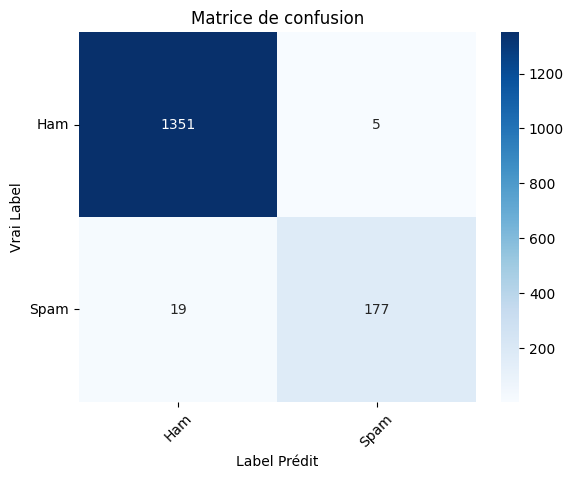

In [554]:
y_pred = svm_optim.best_model.predict(X_test)
fig, ax, svm_report = plot_confusion_matrix(y_test, y_pred, classes=['Ham', 'Spam'])
fig.savefig(figures_path + 'svm_mat.png', bbox_inches='tight')
plt.show()

In [474]:
svm_report

,0,1,accuracy,macro avg,weighted avg
precision,0.986131,0.972527,0.984536,0.979329,0.984413
recall,0.996313,0.903061,0.984536,0.949687,0.984536
f1-score,0.991196,0.936508,0.984536,0.963852,0.984289
support,1356.000000,196.000000,0.984536,1552.000000,1552.000000


## Regression Logistique

In [475]:
lr_optim.best_model.fit(X_train, y_train)
lr_optim.best_model.score(X_test, y_test)

0.976159793814433

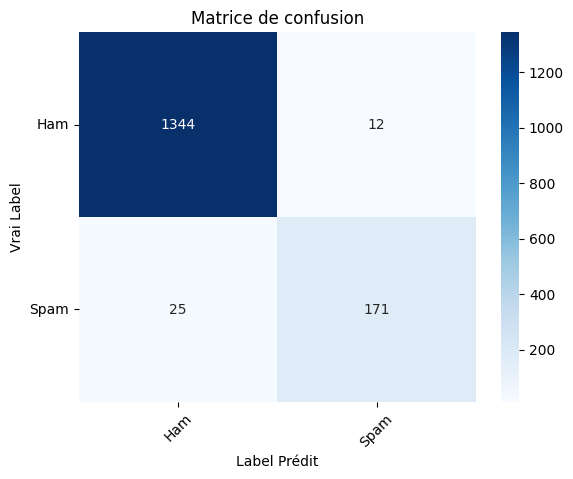

In [555]:
y_pred = lr_optim.best_model.predict(X_test)
fig, ax, lr_report = plot_confusion_matrix(y_test, y_pred, classes=['Ham', 'Spam'])
fig.savefig(figures_path + 'lr_mat.png', bbox_inches='tight')
plt.show()

In [477]:
lr_report

,0,1,accuracy,macro avg,weighted avg
precision,0.981738,0.934426,0.97616,0.958082,0.975763
recall,0.991150,0.872449,0.97616,0.931800,0.976160
f1-score,0.986422,0.902375,0.97616,0.944398,0.975808
support,1356.000000,196.000000,0.97616,1552.000000,1552.000000


## Naive Bayes

### Variante Gaussienne

In [478]:
gnb_optim.best_model.fit(X_train, y_train)
gnb_optim.best_model.score(X_test, y_test)

0.907860824742268

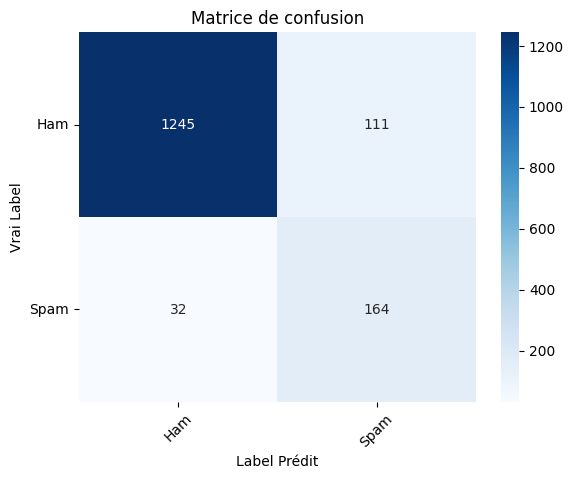

In [556]:
y_pred = gnb_optim.best_model.predict(X_test)
fig, ax, gnb_report = plot_confusion_matrix(y_test, y_pred, classes=['Ham', 'Spam'])
fig.savefig(figures_path + 'gnb_mat.png', bbox_inches='tight')
plt.show()

In [480]:
gnb_report

,0,1,accuracy,macro avg,weighted avg
precision,0.974941,0.596364,0.907861,0.785652,0.927131
recall,0.918142,0.836735,0.907861,0.877438,0.907861
f1-score,0.945689,0.696391,0.907861,0.821040,0.914206
support,1356.000000,196.000000,0.907861,1552.000000,1552.000000


### Variante Multinomiale

In [481]:
mnnb_optim.best_model.fit(X_train, y_train)
mnnb_optim.best_model.score(X_test, y_test)

0.9710051546391752

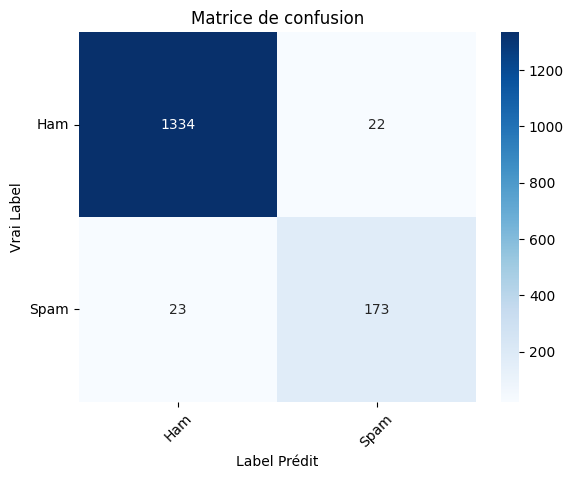

In [557]:
y_pred = mnnb_optim.best_model.predict(X_test)
fig, ax, mnnb_report = plot_confusion_matrix(y_test, y_pred, classes=['Ham', 'Spam'])
fig.savefig(figures_path + 'mnnb_mat.png', bbox_inches='tight')
plt.show()

In [483]:
mnnb_report

,0,1,accuracy,macro avg,weighted avg
precision,0.983051,0.887179,0.971005,0.935115,0.970943
recall,0.983776,0.882653,0.971005,0.933214,0.971005
f1-score,0.983413,0.884910,0.971005,0.934162,0.970973
support,1356.000000,196.000000,0.971005,1552.000000,1552.000000


### Variante Complémentaire

In [484]:
cnb_optim.best_model.fit(X_train, y_train)
cnb_optim.best_model.score(X_test, y_test)

0.9690721649484536

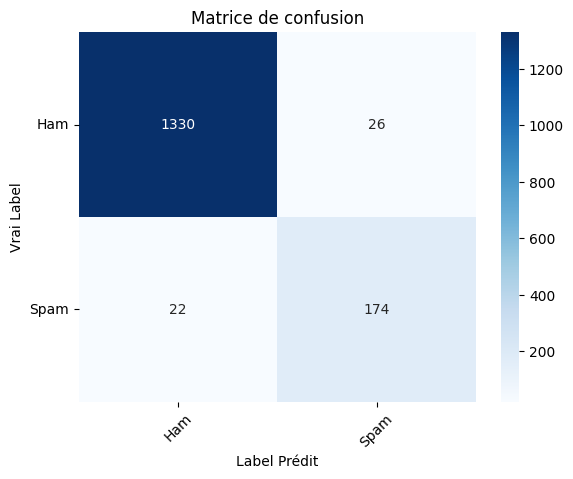

In [558]:
y_pred = cnb_optim.best_model.predict(X_test)
fig, ax, cnb_report = plot_confusion_matrix(y_test, y_pred, classes=['Ham', 'Spam'])
fig.savefig(figures_path + 'cnb_mat.png', bbox_inches='tight')
plt.show()

In [486]:
cnb_report

,0,1,accuracy,macro avg,weighted avg
precision,0.983728,0.870000,0.969072,0.926864,0.969365
recall,0.980826,0.887755,0.969072,0.934291,0.969072
f1-score,0.982275,0.878788,0.969072,0.930531,0.969206
support,1356.000000,196.000000,0.969072,1552.000000,1552.000000


### Variante Bernoulli

In [487]:
bnb_optim.best_model.fit(X_train, y_train)
bnb_optim.best_model.score(X_test, y_test)

0.9349226804123711

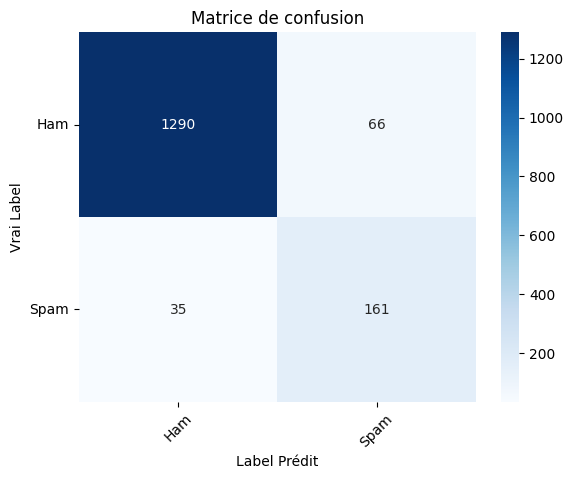

In [559]:
y_pred = bnb_optim.best_model.predict(X_test)
fig, ax, bnb_report = plot_confusion_matrix(y_test, y_pred, classes=['Ham', 'Spam'])
fig.savefig(figures_path + 'bnb_mat.png', bbox_inches='tight')
plt.show()

In [489]:
bnb_report

,0,1,accuracy,macro avg,weighted avg
precision,0.973585,0.709251,0.934923,0.841418,0.940203
recall,0.951327,0.821429,0.934923,0.886378,0.934923
f1-score,0.962327,0.761229,0.934923,0.861778,0.936931
support,1356.000000,196.000000,0.934923,1552.000000,1552.000000


## KNN

In [490]:
knn_optim.best_model.fit(X_train, y_train)
knn_optim.best_model.score(X_test, y_test)

0.9735824742268041

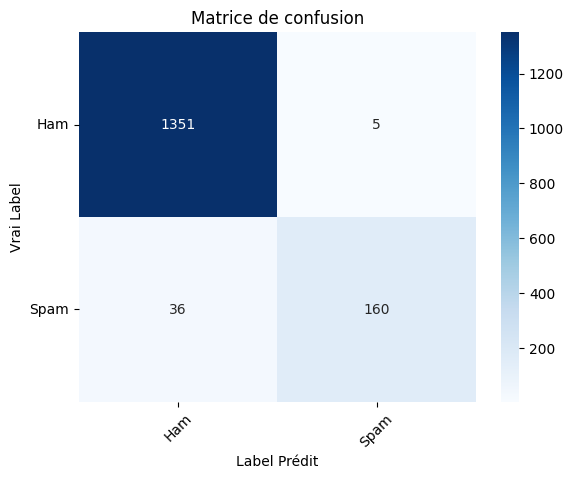

In [560]:
y_pred = knn_optim.best_model.predict(X_test)
fig, ax, knn_report = plot_confusion_matrix(y_test, y_pred, classes=['Ham', 'Spam'])
fig.savefig(figures_path + 'knn_mat.png', bbox_inches='tight')
plt.show()

In [492]:
knn_report

,0,1,accuracy,macro avg,weighted avg
precision,0.974045,0.969697,0.973582,0.971871,0.973496
recall,0.996313,0.816327,0.973582,0.906320,0.973582
f1-score,0.985053,0.886427,0.973582,0.935740,0.972597
support,1356.000000,196.000000,0.973582,1552.000000,1552.000000


## Arbre de Décision

In [493]:
dtc_optim.best_model.fit(X_train, y_train)
dtc_optim.best_model.score(X_test, y_test)

0.9510309278350515

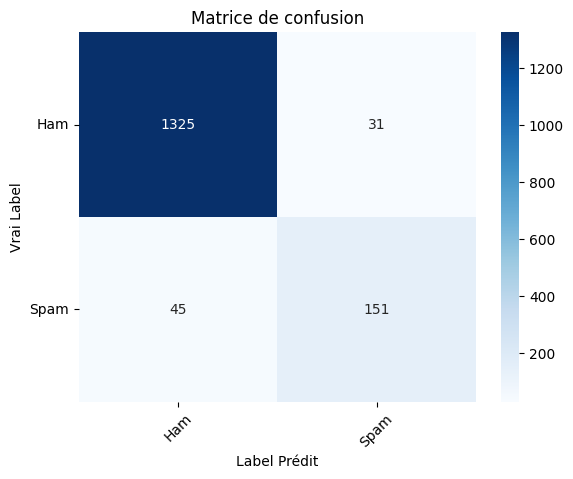

In [494]:
y_pred = dtc_optim.best_model.predict(X_test)
fig, ax, dtc_report = plot_confusion_matrix(y_test, y_pred, classes=['Ham', 'Spam'])
fig.savefig(figures_path + 'dtc_mat.png', bbox_inches='tight')
plt.show()

In [495]:
dtc_report

,0,1,accuracy,macro avg,weighted avg
precision,0.967153,0.829670,0.951031,0.898412,0.949791
recall,0.977139,0.770408,0.951031,0.873773,0.951031
f1-score,0.972120,0.798942,0.951031,0.885531,0.950250
support,1356.000000,196.000000,0.951031,1552.000000,1552.000000


## Random Forest

In [496]:
rnd_optim.best_model.fit(X_train, y_train)
rnd_optim.best_model.score(X_test, y_test)

0.9542525773195877

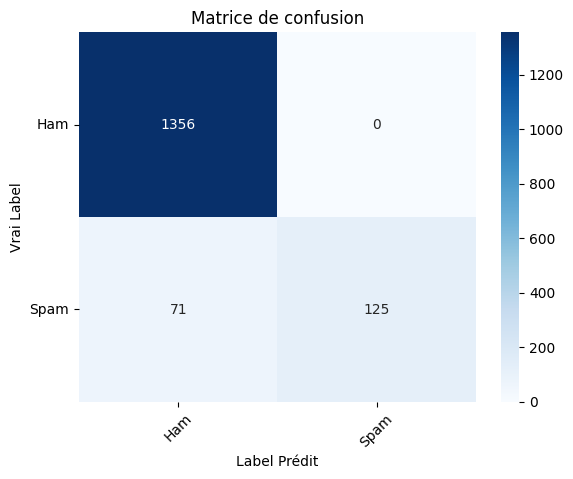

In [497]:
y_pred = rnd_optim.best_model.predict(X_test)
fig, ax, rnd_report = plot_confusion_matrix(y_test, y_pred, classes=['Ham', 'Spam'])
fig.savefig(figures_path + 'rnd_mat.png', bbox_inches='tight')
plt.show()

In [498]:
rnd_report

,0,1,accuracy,macro avg,weighted avg
precision,0.950245,1.000000,0.954253,0.975123,0.956529
recall,1.000000,0.637755,0.954253,0.818878,0.954253
f1-score,0.974488,0.778816,0.954253,0.876652,0.949777
support,1356.000000,196.000000,0.954253,1552.000000,1552.000000


## Comparaison des métriques

In [499]:
models = {'SVM' : svm_report,
         'Log. Reg.' : lr_report,
         'GaussNB' : gnb_report,
         'Multi. NB' : mnnb_report,
         'Compl. NB' : cnb_report,
         'Bern. NB' : bnb_report,
         'kNN' : knn_report,
         'Arbre Dec.' : dtc_report,
         'Random For.' : rnd_report}

In [500]:
metrics = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1'])
for model_name, report in models.items():
    metrics.loc[metrics.shape[0]+1] = [model_name, report.iloc[0,2],report.iloc[0,1], report.iloc[1,1], report.iloc[2,1] ]

In [501]:
metrics

,model,accuracy,precision,recall,f1
1,SVM,0.984536,0.972527,0.903061,0.936508
2,Log. Reg.,0.976160,0.934426,0.872449,0.902375
3,GaussNB,0.907861,0.596364,0.836735,0.696391
4,Multi. NB,0.971005,0.887179,0.882653,0.884910
5,Compl. NB,0.969072,0.870000,0.887755,0.878788
6,Bern. NB,0.934923,0.709251,0.821429,0.761229
7,kNN,0.973582,0.969697,0.816327,0.886427
8,Arbre Dec.,0.951031,0.829670,0.770408,0.798942
9,Random For.,0.954253,1.000000,0.637755,0.778816


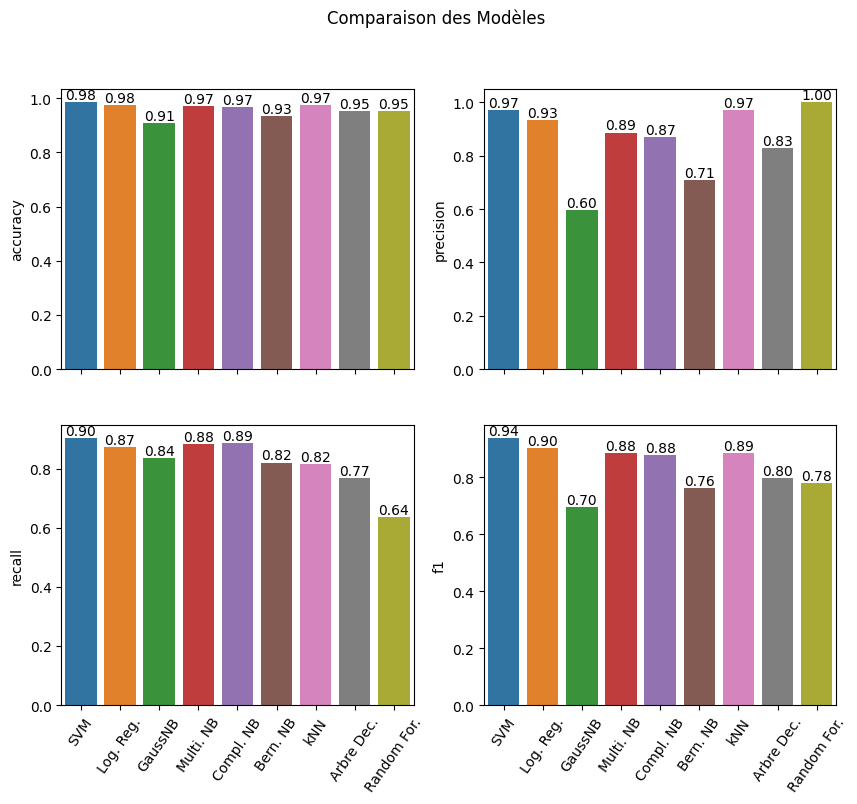

In [550]:
fig, ax = plt.subplots(2,2, figsize=(10,8), sharex=True, squeeze=True)
ax[0,0] = sns.barplot(metrics, y="accuracy", x="model", hue="model", legend=False, ax=ax[0,0])
for container in ax[0,0].containers: ax[0,0].bar_label(container, fmt="%.2f")
ax[0,1] = sns.barplot(metrics, y="precision", x="model", hue="model", legend=False, ax=ax[0,1])
for container in ax[0,1].containers: ax[0,1].bar_label(container, fmt="%.2f")
ax[1,0] = sns.barplot(metrics, y="recall", x="model", hue="model", legend=False, ax=ax[1,0])
for container in ax[1,0].containers: ax[1,0].bar_label(container, fmt="%.2f")
ax[1,1] = sns.barplot(metrics, y="f1", x="model", hue="model", legend=False, ax=ax[1,1])
for container in ax[1,1].containers: ax[1,1].bar_label(container, fmt="%.2f")
ax[0,0].tick_params(axis='x', labelrotation=55)
ax[0,1].tick_params(axis='x', labelrotation=55)
ax[1,0].tick_params(axis='x', labelrotation=55)
ax[1,1].tick_params(axis='x', labelrotation=55)
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('')
plt.suptitle('Comparaison des Modèles')
fig.savefig(figures_path + 'comparaison.png', bbox_inches='tight')
plt.show()

Le model qui semble être le plus intéressant est le **SVM**.

## Courbe ROC

In [503]:
models_optim = {'SVM' : svm_optim,
         'Log. Reg.' : lr_optim,
         'GaussNB' : gnb_optim,
         'Multi. NB' : mnnb_optim,
         'Compl. NB' : cnb_optim,
         'Bern. NB' : bnb_optim,
         'kNN' : knn_optim,
         'Arbre Dec.' : dtc_optim,
         'Random For.' : rnd_optim}

/tmp/ipykernel_875638/3032385417.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


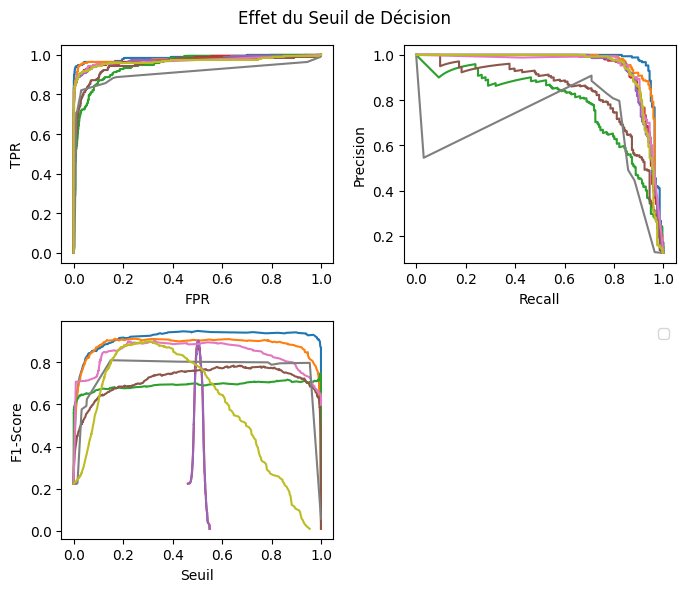

In [551]:
fig, ax = plt.subplots(2,2, figsize=(7,6),)
roc = {}
for model_name, optim in models_optim.items():
    y_scores = optim.best_model.predict_proba(X_test)[:,1]
    tpr, fpr, _ = roc_curve(y_test, y_scores)
    pre, rec, thr = precision_recall_curve(y_test, y_scores)
    f1 = 2*pre*rec/(pre+rec)
    ax[0,0].plot(tpr, fpr, label=model_name)
    ax[0,1].plot(rec,pre, label=model_name)
    ax[1,0].plot(thr, f1[:-1], label=model_name)
ax[0,0].set_xlabel('FPR')
ax[0,0].set_ylabel('TPR')
ax[0,1].set_ylabel('Precision')
ax[0,1].set_xlabel('Recall')
ax[1,0].set_xlabel('Seuil')
ax[1,0].set_ylabel('F1-Score')
ax[1,1].axis('off')
lines = []
labels = []

line, label = ax[0,0].get_legend_handles_labels()
lines.extend(line)
labels.extend(label)
line, label = ax[0,1].get_legend_handles_labels()
lines.extend(line)
labels.extend(label)
line, label = ax[1,0].get_legend_handles_labels()
lines.extend(line)
labels.extend(label)
ax[1,1].legend(lines, labels, loc='center')
plt.suptitle('Effet du Seuil de Décision')
plt.legend()
plt.tight_layout()
fig.savefig(figures_path + 'seuil.png', bbox_inches='tight')
plt.show()

# Choix du model

In [566]:
from joblib import dump, load

In [565]:
dump(svm_optim.best_model, model_path + 'svm.pkl')

['svm.pkl']

In [567]:
svm_optim.best_model.score(X_test,y_test)

0.9845360824742269

In [568]:
try_optim = load(model_path + 'svm.pkl')

In [569]:
try_optim.score(X_test,y_test)

0.9845360824742269

In [570]:
X_test

5079    want new nokia 3510i colour phone deliveredtom...
2071    sexy single waiting ! text age followed gender...
2152    surely dont forgot comeemoticoni always touch ...
3825    miss much 'm desparate recorded message left d...
2086                            moji love word . rich day
                              ...                        
2538                           's haf combine n c lor ...
3597             good morning princess ! happy new year !
5380    free entry gr8prizes wkly comp 4 chance win la...
157                                  'm leaving house ...
2018                   better bb . wont use , wife doctor
Name: sms, Length: 1552, dtype: object

In [571]:
y_test

5079    1
2071    1
2152    0
3825    0
2086    0
       ..
2538    0
3597    0
5380    1
157     0
2018    0
Name: class, Length: 1552, dtype: int64

In [573]:
df_msg.iloc[5079].values

array(['spam',
       "urgent ! last weekend 's draw show £1000 cash spanish holiday ! call 09050000332 claim . tandc : rstm , sw7 3ss . 150ppm",
       np.int64(120), np.int64(8)], dtype=object)

In [575]:
X_test.loc[5079]

'want new nokia 3510i colour phone deliveredtomorrow ? 300 free minute mobile + 100 free text + free camcorder reply call 08000930705 .'